In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Mounted at /content/drive


In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/1.PTDLKD/Dataset/VNDIRECT_STOCK.csv')
df1=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 13s 454ms/step - loss: 0.0245 - val_loss: 0.0415
Epoch 2/100
14/14 [==============================] - 3s 215ms/step - loss: 0.0051 - val_loss: 0.0098
Epoch 3/100
14/14 [==============================] - 3s 238ms/step - loss: 0.0028 - val_loss: 0.0085
Epoch 4/100
14/14 [==============================] - 3s 212ms/step - loss: 0.0021 - val_loss: 0.0075
Epoch 5/100
14/14 [==============================] - 5s 357ms/step - loss: 0.0019 - val_loss: 0.0072
Epoch 6/100
14/14 [==============================] - 3s 208ms/step - loss: 0.0018 - val_loss: 0.0066
Epoch 7/100
14/14 [==============================] - 3s 209ms/step - loss: 0.0016 - val_loss: 0.0064
Epoch 8/100
14/14 [==============================] - 3s 211ms/step - loss: 0.0015 - val_loss: 0.0063
Epoch 9/100
14/14 [==============================] - 4s 319ms/step - loss: 0.0013 - val_loss: 0.0060
Epoch 10/100
14/14 [==============================] - 3s 241ms/step - loss: 0.0013 - val_l

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 28ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [12]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 728.2617199148194
Testing RMSE: 1547.668980471099


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# 13 Đánh giá độ chính xác thuật toán bằng MAE
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 608.5267366976351
Testing MAE: 1232.3250632225436


In [14]:
# 14 Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = (np.sum(np.abs((yval-y_pred_val)/yval))/len(yval))*100
test_mape = (np.sum(np.abs((ytest-y_pred)/ytest))/len(ytest))*100
print(f"Validation MAPE: {valid_mape:.2f}%")
print(f"Testing MAPE: {test_mape:.2f}%")

Validation MAPE: 3.64%
Testing MAPE: 5.51%


In [15]:
# 15. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=78
i=0
while(i<30):

    if(len(temp_input)>78):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.48394692]
79
1 day input [0.37017602 0.35465111 0.33602121 0.3375737  0.36241357 0.35154613
 0.34223118 0.34999363 0.36086107 0.37638599 0.37638599 0.37017602
 0.37017602 0.35465111 0.38414844 0.37949097 0.38570093 0.36551855
 0.37949097 0.37949097 0.39035841 0.39501588 0.39967336 0.39346339
 0.39812086 0.39346339 0.40122585 0.41364578 0.42296073 0.42296073
 0.40588332 0.41054079 0.41364578 0.41364578 0.40433083 0.3919109
 0.38104346 0.38259595 0.3919109  0.38259595 0.38104346 0.38725343
 0.38414844 0.373281   0.3748335  0.37172851 0.38259595 0.38570093
 0.37793848 0.39035841 0.38725343 0.39501588 0.40277834 0.41209329
 0.40122585 0.40433083 0.39346339 0.40122585 0.41985574 0.42296073
 0.43072318 0.41985574 0.41209329 0.41519827 0.44935308 0.46022052
 0.4633255  0.48506038 0.48816536 0.4804029  0.51921518 0.51766269
 0.48195539 0.50834775 0.50524276 0.4990328  0.50058529 0.48394692]
1 day output [[0.47517037]]
2 day input [0.35465111 0.33602121 0.3375737  0.36241357 0.35154613 0.342

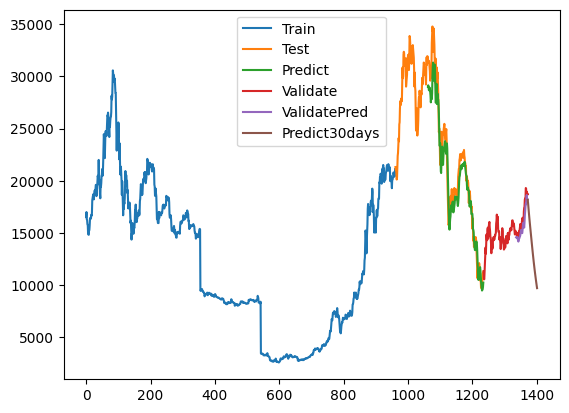

In [16]:
# 16.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [17]:
scaler.inverse_transform(lst_output)

array([[18164.1396716 ],
       [17881.47961347],
       [17518.15414981],
       [17150.59202948],
       [16794.61016804],
       [16451.80667002],
       [16120.33387702],
       [15796.98118268],
       [15478.40936438],
       [15161.99522715],
       [14846.21553261],
       [14530.64507938],
       [14215.74362246],
       [13902.55544877],
       [13592.38591695],
       [13286.57589909],
       [12986.28102151],
       [12692.40543706],
       [12405.56439196],
       [12126.08230625],
       [11854.05324252],
       [11589.38217835],
       [11331.8541135 ],
       [11081.16766367],
       [10836.99552939],
       [10598.98881517],
       [10366.80870365],
       [10140.1384534 ],
       [ 9918.68483863],
       [ 9702.18054876]])